In [1]:
# Enables figures loading outside of browser.
# If not run, figures will load inline.
#%matplotlib

import os
import math
import pandas as pd
import numpy as np
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import matplotlib.ticker
import datetime
import collections
import itertools

from scipy import stats

# Depends on: pip install sklearn
from sklearn.model_selection import train_test_split

# Some matplotlib features are version dependent.
assert(matplotlib.__version__ >= '2.1.2')

# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='measurement-lab'):
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=3000):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

def unlog(x, pos):
    """Formats the x axis for histograms taken on the log of values."""
    v = math.pow(10, x)
    frac, whole = math.modf(v)
    if frac > 0:
        return '%.1f' % v
    else:
        return '%d' % whole
    
    
def hist(vals, bin_count, log=True, cdf=False):
    """Produces hist or cdf values for smooth plots."""
    if log:
        r = [math.log10(x) for x in vals]
    else:
        r = vals
        
    m, bins = np.histogram(r, bin_count, normed=True)
    m = m.astype(float)

    tops = m
    if cdf:
        tops = np.cumsum(m)
        total = sum(m)
        tops = [float(t) / total for t in tops]
    
    return tops, bins


logFormatter = matplotlib.ticker.FuncFormatter(unlog)

/usr/local/google/home/soltesz/.local/lib/python2.7/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def plot_df(
    df, xname='', yname='',
    cname='', bins=None, cdf=False,
    xlog=None, ylog=False,
    fig_by='', axes_by='', group_by='',
    figsize=(6,8), axes=(1,1),
    label='{group}',
    xlabel='', ylabel='',
    xlim=(), ylim=(),
    fx=list, fy=list,
    suptitle='',
    title='',
    legend={},
    figmap=None,
    fxn=None,
    info=False):
    """Creates a scatter or histogram plot from df, split on mulitple dimension.

    plot_df helps plot structured data frames as simple scatter or histograms by
    slicing the dataframe along distinct values of some column names. For
    example, a df that includes a "state" column could be used to create a new
    figure for every state with the `fig_by="state"` parameter. Within a single
    figure, it's possible to slice the data into multiple axes using another
    column, for example one named "city" using `axes_by="city"`.

    Args:
      df: pandas.DataFrame, structured data to plot.
      xname: str, name of df column to use as x-axis. Use only with yname.
      yname: str, name of df column to use as y-axis. Use only with xname.
      cname: str, name of df column to calculate the histogram. Use only with
          cdf, and bins.
      cdf: bool, whether to plot histogram as a CDF. Default is as a PDF. Use
          only with cname and bins.
      bins: int or callable, the number of histogram bins. May be a function.
      xlog: bool, whether to take the log of histogram. Use only with cname.
      ylog: bool, whether to plot the y axis using semilog scale.
      fig_by: str, name of column where distinct values split data into multiple
          figures.
      axes_by: str, name of column where distinct values split data into
          multiple axis panels on a single figure.
      group_by: str, name of column where distinct values are all plotted on the
          same axis.
      figsize: (int, int), dimensions of figure. Default (6, 8).
      axes: (int, int), arrangement of axes within figure. Default (1, 1).
      label: str, the legend format per data series. Used as a format string.  x
          Other parameters available are {figure}, {axis}, {size}.
          Default {group}.
      xlabel: str, the xlabel value. Used as a format string. Other parameters
          available are {figure}, {axis}, {size}.
      ylabel: str, the ylabel value. Used as a format string like xlabel.
      xlim: (xmin, xmax), explicitly set minimum and maximum values of x axis.
      ylim: (ymin, ymax), explicitly set minimum and maximum values of y axis.
      fx: func, if set, operate on x axis series data before plotting.
      fy: func, if set, operate on y axis series data before plotting.
      suptitle: str, figure title.
      title: str, axis title.
      legend: **legend_args,
      figmap: the figmap value returned by an earlier cal of plot_df. May be
          used to overlay values from multiple data frames. Must use the same
          fig_by, axes_by, and group_by values.
      fxn: callable that accepts parameters (r, **kwargs). Kwargs will include
          figure, axis, group, names and data set size. Only called for
          histogram plots.
      info: bool, whether to log additional info messages.
    Returns:
      dict of str to (figures, axes) tuples
    """
    def log_info(f):
        if info:
            print f

    if figmap is None:
        log_info('new figmap')
        figmap = {}
    scatter = None
    if (xname and yname):
        scatter = True
    if cname:
        scatter = False
    if scatter is None:
        raise Exception('Provide xname and yname or cname')

    default_names = set(['default'])

    figure_names = set(df[fig_by]) if fig_by else default_names
    for f in sorted(figure_names):
        if f in figmap:
            log_info('loading figmap for %s' % f)
            fig, ax, ax_index = figmap[f]
        else:
            fig = plt.figure(figsize=figsize)
            ax = fig.subplots(axes[0], axes[1], squeeze=False)
            ax_index = list(itertools.product(range(axes[0]), range(axes[1])))
            log_info('saving figmap for %s' % f)
            figmap[f] = (fig, ax, ax_index)

        df_fig = df if f == 'default' else df[df[fig_by] == f]

        axes_names = set(df_fig[axes_by]) if axes_by else default_names
        for p, a in enumerate(sorted(axes_names)):
            if p >= len(ax_index):
                print 'SKIPPING', p, f, a, 'too few axes positions'
                continue

            if a == 'default':
                df_axes = df_fig
            else:
                df_axes = df_fig[df_fig[axes_by] == a]

            i, j = ax_index[p]
            group_names = set(df_axes[group_by]) if group_by else default_names
            for g in sorted(group_names):
                if g == 'default':
                    df_g = df_axes
                else:
                    df_g = df_axes[df_axes[group_by] == g]

                if scatter:
                    x = fx(df_g[xname])
                    y = fy(df_g[yname])
                    l = label.format(figure=f, axis=a, group=g)
                    ax[i][j].scatter(x, y, s=1, label=l)

                else:
                    r = df_g[cname]
                    if bins is None:
                        size = int(math.sqrt(len(r)))
                    else:
                        size = bins(r)
                    if fxn:
                        result = fxn(r, figure=f, axis=a, group=g, size=size)
                    log_info("%s %s %s %s %s" % (f, a, g, size, len(r)))
                    h_tops, h_bins = hist(r, size, log=xlog , cdf=cdf)
                    l = label.format(figure=f, axis=a, group=g, size=size, result=result)
                    ax[i][j].plot(h_bins[:-1], h_tops, label=l)

            if i != len(ax)-1:
                ax[i][j].set_xticklabels([])

            if title:
                ax[i][j].set_title(title.format(figure=f, axis=a, group=g))
            if ylabel:
                ax[i][j].set_ylabel(ylabel.format(figure=f, axis=a, group=g))
            if xlabel:
                ax[i][j].set_xlabel(xlabel.format(figure=f, axis=a, group=g))

            if xlim:
                ax[i][j].set_xlim(xlim)
            if ylim:
                ax[i][j].set_ylim(ylim)

            ax[i][j].grid(color='#dddddd')
            ax[i][j].legend(fontsize='x-small', **legend)
            if scatter:
                ax[i][j].tick_params(axis='x', labelrotation=-90)
            if xlog:
                ax[i][j].xaxis.set_major_formatter(logFormatter)
            if ylog:
                ax[i][j].semilogy()

        if suptitle:
            fig.suptitle(suptitle.format(figure=f))
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    return figmap


def plot_scatter(df, xname, yname, **kwargs):
    return plot_df(df, xname=xname, yname=yname, **kwargs)


def plot_hist(df, cname, bins=None, **kwargs):
    return plot_df(df, cname=cname, bins=bins, **kwargs)


# Daily Median Uplink Utilization

In [3]:
df_disco_pct = run_query("""
#standardSQL

WITH measurementlab_switch_dedup AS (
  SELECT
    metric,
    REGEXP_EXTRACT(hostname, r'(mlab[1-4].[a-z]{3}[0-9]{2}).*') AS hostname,
    sample.timestamp AS ts,
    sample.value AS value
  FROM
    `measurement-lab.base_tables.switch*`,
    UNNEST(sample) AS sample
  WHERE
        metric = 'switch.octets.uplink.tx'
    AND REGEXP_CONTAINS(hostname, r"mlab1.(dfw|lga|nuq)\d\d")
  GROUP BY
    hostname, metric, ts, value
)


SELECT
  UPPER(REGEXP_EXTRACT(hostname, r'mlab1.([a-z]{3})[0-9]{2}.*')) AS metro,
  REGEXP_EXTRACT(hostname, r'mlab1.([a-z]{3}[0-9]{2}).*') AS site,
  UNIX_SECONDS(TIMESTAMP_TRUNC(ts, DAY)) AS ts,  
  0.8 * APPROX_QUANTILES(value, 101)[ORDINAL(50)] as bytes_50th

FROM
  measurementlab_switch_dedup

WHERE
  hostname IS NOT NULL

GROUP BY
  hostname, ts

ORDER BY
  hostname, ts
""")

{'default': (<Figure size 576x720 with 3 Axes>,
  array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb071459190>],
        dtype=object),
  [(0, 0), (1, 0), (2, 0)])}

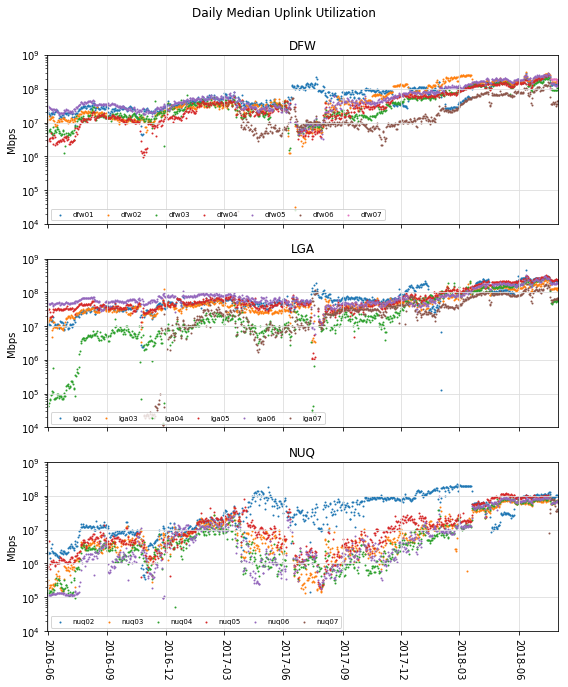

In [4]:
plot_scatter(
    df_disco_pct, 'ts', 'bytes_50th',
    axes_by='metro', group_by='site',
    axes=(3, 1), figsize=(8, 10),
    suptitle='Daily Median Uplink Utilization',
    ylabel="Mbps",
    title='{axis}',
    xlim=(pd.to_datetime("2016-05-31"), pd.to_datetime("2018-08-01")),
    ylim=(1e4, 1e9),
    fx=lambda l: [pd.to_datetime(t, unit='s') for t in l],
    legend={'loc':3, 'ncol':7, 'columnspacing':1},
    ylog=True)

# Daily Packet Loss Ratio

In [5]:
df_disco_ratio = run_query("""
#standardSQL

WITH measurementlab_switch_dedup AS (
  SELECT
    metric,
    REGEXP_EXTRACT(hostname, r'(mlab[1-4].[a-z]{3}[0-9]{2}).*') AS hostname,
    sample.timestamp AS ts,
    sample.value AS value
    
  FROM
    `measurement-lab.base_tables.switch*`,
    UNNEST(sample) AS sample
    
  WHERE
        (metric LIKE 'switch.discards.uplink.tx'
      OR metric LIKE 'switch.unicast.uplink.tx')
    AND REGEXP_CONTAINS(hostname, r"mlab1.(dfw|lga|nuq)\d\d")
    
  GROUP BY
    hostname, metric, ts, value
)

SELECT
  UPPER(REGEXP_EXTRACT(hostname, r'mlab1.([a-z]{3})[0-9]{2}.*')) AS metro,
  REGEXP_EXTRACT(hostname, r'mlab1.([a-z]{3}[0-9]{2}).*') AS site,
  hostname,
  ts,
  IF(total > 0, discards / total, 0) as ratio

FROM (
  SELECT
    hostname,
    UNIX_SECONDS(TIMESTAMP_TRUNC(ts, DAY)) AS ts,
    SUM(IF(metric = "switch.discards.uplink.tx", value, 0)) AS discards,
    SUM(IF(metric = "switch.unicast.uplink.tx", value, 0)) AS total
  FROM
    measurementlab_switch_dedup
  WHERE
    hostname IS NOT NULL
  GROUP BY
    hostname, ts
  HAVING
    discards < total
  ORDER BY
    hostname, ts
)
GROUP BY
  hostname, ts, ratio
HAVING
  ratio < 0.01
ORDER BY
  hostname, ts
""")

{'default': (<Figure size 576x720 with 3 Axes>,
  array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0701af550>],
        dtype=object),
  [(0, 0), (1, 0), (2, 0)])}

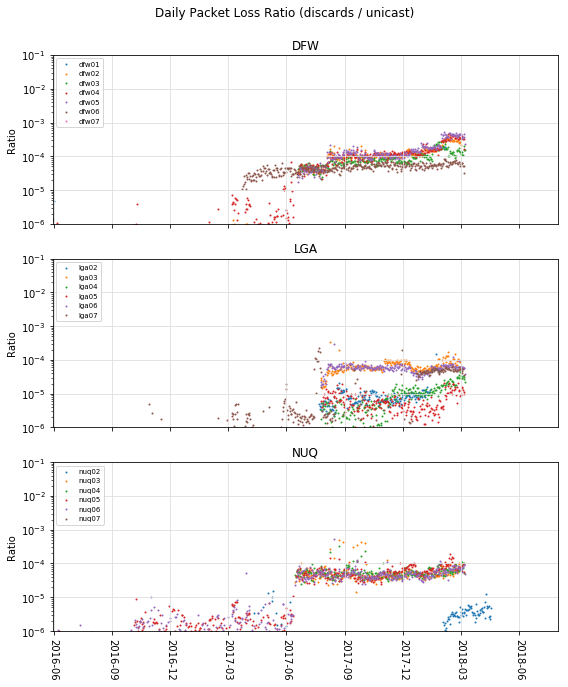

In [6]:
plot_scatter(
    df_disco_ratio, 'ts', 'ratio',
    axes_by='metro', group_by='site',
    axes=(3, 1), figsize=(8, 10),
    suptitle='Daily Packet Loss Ratio (discards / unicast)',
    ylabel="Ratio",
    title='{axis}',
    xlim=(pd.to_datetime("2016-05-31"), pd.to_datetime("2018-08-01")),
    ylim=(1e-6, 1e-1),
    fx=lambda l: [pd.to_datetime(t, unit='s') for t in l],
    legend={'loc':2},
    ylog=True)

# Median NDT Download Rates

In [7]:
df_ndt_all = run_query("""
WITH measurementlab_ndt_dedup AS (
  SELECT
    UPPER(REGEXP_EXTRACT(connection_spec.server_hostname, r"([a-z]{3})[0-9]{2}")) as metro,
    REGEXP_EXTRACT(connection_spec.server_hostname, r"([a-z]{3}[0-9]{2})") as site,
    web100_log_entry.connection_spec.remote_ip as remote_ip,
    log_time,
    (8 * (web100_log_entry.snap.HCThruOctetsAcked / (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd))) AS download_mbps

  FROM
    `measurement-lab.release.ndt_all`

  WHERE
        REGEXP_CONTAINS(connection_spec.server_hostname, r"(lga|dfw|nuq)\d\d")
    AND web100_log_entry.snap.HCThruOctetsAcked >= 1000000
    AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) >= 9000000
    AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) < 600000000
    AND connection_spec.data_direction = 1
    AND web100_log_entry.connection_spec.remote_ip != "45.56.98.222"
    AND web100_log_entry.connection_spec.remote_ip != "2600:3c03::f03c:91ff:fe33:819"
    AND web100_log_entry.connection_spec.remote_ip != "35.225.75.192"
    AND web100_log_entry.connection_spec.remote_ip != "35.192.37.249"
    AND web100_log_entry.connection_spec.remote_ip != "35.193.254.117"
    AND log_time >= TIMESTAMP("2016-06-01")

  GROUP BY
    connection_spec.server_hostname,
    log_time,
    web100_log_entry.connection_spec.remote_ip,
    web100_log_entry.connection_spec.local_ip,
    web100_log_entry.connection_spec.remote_port,
    web100_log_entry.connection_spec.local_port,
    download_mbps
)
    
SELECT
  metro,
  site,
  day,
  APPROX_QUANTILES(download_mbps, 101)[ORDINAL(50)] as download_mbps,
  count(*) as count

FROM
(
  SELECT
    metro,
    site,
    TIMESTAMP_TRUNC(log_time, DAY) as day,
    MAX(download_mbps) as download_mbps

  FROM
    measurementlab_ndt_dedup

  GROUP BY
    metro, site, day, remote_ip
)

GROUP BY
  metro, site, day

ORDER BY
  day
""")


{'default': (<Figure size 576x720 with 3 Axes>,
  array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb070104fd0>],
        dtype=object),
  [(0, 0), (1, 0), (2, 0)])}

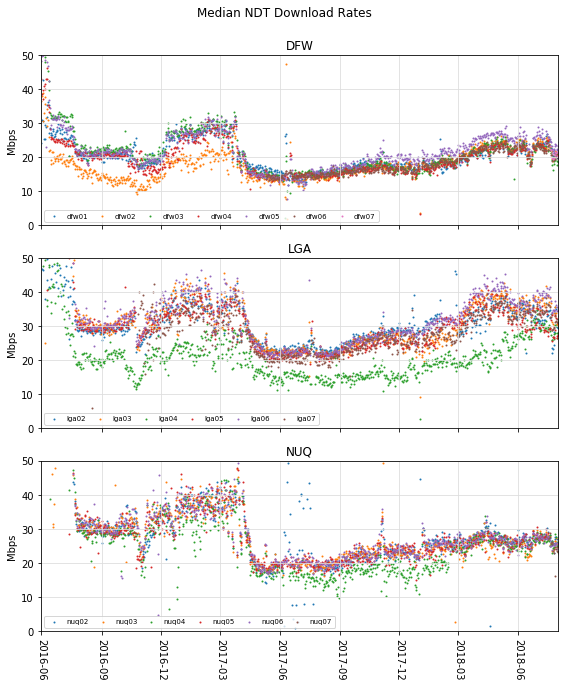

In [8]:
plot_scatter(
    df_ndt_all, 'day', 'download_mbps',
    axes_by='metro', group_by='site',
    axes=(3, 1), figsize=(8, 10),
    suptitle='Median NDT Download Rates',
    ylabel="Mbps",
    title='{axis}',
    xlim=(pd.to_datetime("2016-05-31"), pd.to_datetime("2018-08-01")),
    ylim=(0, 50),
    fx=lambda l: [pd.to_datetime(t) for t in l],
    legend={'loc':3, 'ncol':7, 'columnspacing':1})

# Median NDT Retransmission Ratio

In [9]:
df_ndt_retrans = run_query("""
WITH measurementlab_ndt_dedup AS (
  SELECT
    connection_spec.server_hostname as hostname,
    web100_log_entry.connection_spec.remote_ip as remote_ip,
    log_time,
    web100_log_entry.snap.SegsRetrans as SegsRetrans,
    web100_log_entry.snap.SegsOut as SegsOut

  FROM
    `measurement-lab.release.ndt_all`

  WHERE
        REGEXP_CONTAINS(connection_spec.server_hostname, r"(lga|dfw|nuq)\d\d")
    AND web100_log_entry.snap.HCThruOctetsAcked >= 1000000
    AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) >= 9000000
    AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) < 600000000
    AND connection_spec.data_direction = 1
    AND web100_log_entry.connection_spec.remote_ip != "45.56.98.222"
    AND web100_log_entry.connection_spec.remote_ip != "2600:3c03::f03c:91ff:fe33:819"
    AND web100_log_entry.connection_spec.remote_ip != "35.225.75.192"
    AND web100_log_entry.connection_spec.remote_ip != "35.192.37.249"
    AND web100_log_entry.connection_spec.remote_ip != "35.193.254.117"
    AND log_time >= TIMESTAMP("2016-06-01")
  
  GROUP BY
    connection_spec.server_hostname,
    log_time,
    web100_log_entry.connection_spec.remote_ip,
    web100_log_entry.connection_spec.local_ip,
    web100_log_entry.connection_spec.remote_port,
    web100_log_entry.connection_spec.local_port,
    SegsRetrans,
    SegsOut
)
    
SELECT
  UPPER(REGEXP_EXTRACT(hostname, r"([a-z]{3})[0-9]{2}")) as metro,
  REGEXP_EXTRACT(hostname, r"([a-z]{3}[0-9]{2})") as site,
  day,
  APPROX_QUANTILES(ratio, 101)[ORDINAL(50)] AS median_ratio,
  count(*) as count
FROM
(
  SELECT
    hostname,
    TIMESTAMP_TRUNC(log_time, DAY) as day,
    MAX(SAFE_DIVIDE(SegsRetrans, SegsOut)) as ratio

  FROM
    measurementlab_ndt_dedup

  GROUP BY
    hostname,
    day,
    remote_ip
)

GROUP BY
  hostname, day

ORDER BY
  day
""")

{'default': (<Figure size 576x720 with 3 Axes>,
  array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb06fa31f90>],
        dtype=object),
  [(0, 0), (1, 0), (2, 0)])}

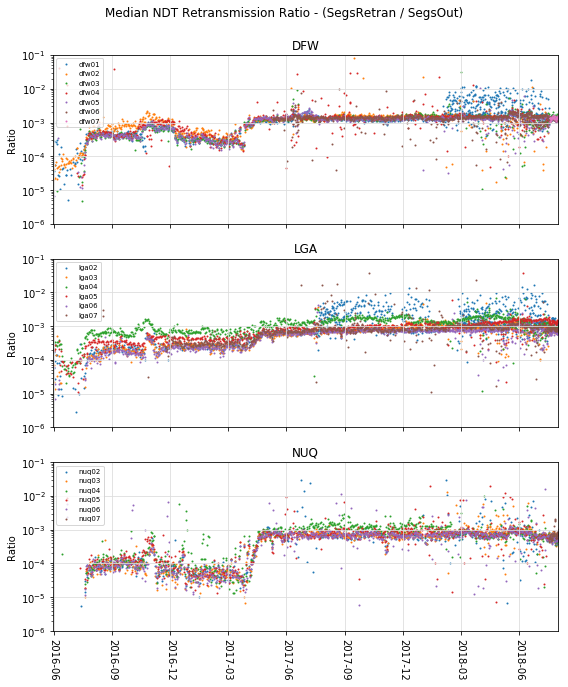

In [10]:
plot_scatter(
    df_ndt_retrans, 'day', 'median_ratio',
    axes_by='metro', group_by='site',
    axes=(3, 1), figsize=(8, 10),
    suptitle='Median NDT Retransmission Ratio - (SegsRetran / SegsOut)',
    ylabel="Ratio",
    title='{axis}',
    xlim=(pd.to_datetime("2016-05-31"), pd.to_datetime("2018-08-01")),
    ylim=(1e-6, 1e-1),
    fx=lambda l: [pd.to_datetime(t) for t in l],
    legend={'loc':2},
    ylog=True)

# Distribution of NDT Downloads

In [11]:
df_ndt_variance = run_query("""
WITH mlab_ndt AS (
  SELECT
    connection_spec.server_hostname as server_hostname,
    log_time,
    web100_log_entry.connection_spec.remote_ip AS remote_ip,
    (8 * (web100_log_entry.snap.HCThruOctetsAcked / (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd))) AS download_mbps
  FROM
    `measurement-lab.base_tables.ndt*`
  WHERE

  (    TIMESTAMP_TRUNC(log_time, DAY) BETWEEN TIMESTAMP("2018-02-11") AND TIMESTAMP("2018-02-25")
    OR TIMESTAMP_TRUNC(log_time, DAY) BETWEEN TIMESTAMP("2018-03-11") AND TIMESTAMP("2018-03-25"))
  AND REGEXP_CONTAINS(connection_spec.server_hostname, r"mlab1.dfw\d\d")
  AND web100_log_entry.snap.HCThruOctetsAcked >= 1000000
  AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) >= 9000000
  AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) < 600000000
  AND connection_spec.data_direction = 1
  
  GROUP BY
    server_hostname,
    log_time,
    web100_log_entry.connection_spec.remote_ip,
    web100_log_entry.connection_spec.local_ip,
    web100_log_entry.connection_spec.remote_port,
    web100_log_entry.connection_spec.local_port,
    download_mbps
    
), measurementlab_ndt_dedup AS (

  SELECT
    UPPER(REGEXP_EXTRACT(connection_spec.server_hostname, r'mlab[1-4].([a-z]{3})[0-9]{2}.*')) AS metro,
    REGEXP_EXTRACT(connection_spec.server_hostname, r'mlab[1-4].([a-z]{3}[0-9]{2}).*') AS site,
    REGEXP_EXTRACT(connection_spec.server_hostname, r'(mlab[1-4].[a-z]{3}[0-9]{2}).*') AS hostname,
    web100_log_entry.connection_spec.remote_ip as remote_ip,
    log_time,
    (8 * (web100_log_entry.snap.HCThruOctetsAcked / (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd))) AS download_mbps

  FROM
    `measurement-lab.release.ndt_all`

  WHERE
      (TIMESTAMP_TRUNC(log_time, DAY) BETWEEN TIMESTAMP("2018-02-11") AND TIMESTAMP("2018-02-25")
    OR TIMESTAMP_TRUNC(log_time, DAY) BETWEEN TIMESTAMP("2018-03-11") AND TIMESTAMP("2018-03-25"))
    AND REGEXP_CONTAINS(connection_spec.server_hostname, r"(dfw)\d\d")
    AND web100_log_entry.snap.HCThruOctetsAcked >= 1000000
    AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) >= 9000000
    AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) < 600000000
    AND connection_spec.data_direction = 1
    AND web100_log_entry.connection_spec.remote_ip != "45.56.98.222"
    AND web100_log_entry.connection_spec.remote_ip != "2600:3c03::f03c:91ff:fe33:819"
    AND web100_log_entry.connection_spec.remote_ip != "35.225.75.192"
    AND web100_log_entry.connection_spec.remote_ip != "35.192.37.249"
    AND web100_log_entry.connection_spec.remote_ip != "35.193.254.117"
    AND log_time >= TIMESTAMP("2016-06-01")

  GROUP BY
    connection_spec.server_hostname,
    log_time,
    web100_log_entry.connection_spec.remote_ip,
    web100_log_entry.connection_spec.local_ip,
    web100_log_entry.connection_spec.remote_port,
    web100_log_entry.connection_spec.local_port,
    download_mbps
)


SELECT
  metro,
  site,
  hostname,
  CASE
    WHEN TIMESTAMP_TRUNC(log_time, DAY) BETWEEN TIMESTAMP("2018-02-11") AND TIMESTAMP("2018-02-25") THEN 'before-2w'
    WHEN TIMESTAMP_TRUNC(log_time, DAY) BETWEEN TIMESTAMP("2018-03-11") AND TIMESTAMP("2018-03-25") THEN 'after-2w'
    ELSE 'what'
  END AS period,
  remote_ip,
  STDDEV(download_mbps) AS download_stddev,
  (STDDEV(download_mbps) / AVG(download_mbps)) AS download_cv,
  MAX(download_mbps) AS download_max,
  MIN(download_mbps) AS download_min,
  AVG(download_mbps) AS download_avg

FROM
  measurementlab_ndt_dedup
  
WHERE
  remote_ip IN(
    SELECT remote_ip
    FROM (
      SELECT   remote_ip, count(*) as c1
      FROM     measurementlab_ndt_dedup
      WHERE    TIMESTAMP_TRUNC(log_time, DAY) BETWEEN TIMESTAMP("2018-02-11") AND TIMESTAMP("2018-02-25")
      GROUP BY remote_ip
      HAVING   c1 > 10
    ) INNER JOIN (
      SELECT   remote_ip AS remote_ip, count(*) as c2
      FROM     measurementlab_ndt_dedup
      WHERE    TIMESTAMP_TRUNC(log_time, DAY) BETWEEN TIMESTAMP("2018-03-11") AND TIMESTAMP("2018-03-25")
      GROUP BY remote_ip
      HAVING   c2 > 10
    ) USING (remote_ip)) 

GROUP BY
  metro, site, hostname, period, remote_ip

HAVING
  download_stddev is not NULL
""")

{u'DFW': (<Figure size 648x504 with 6 Axes>,
  array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb06e013c50>,
        dtype=object),
  [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)])}

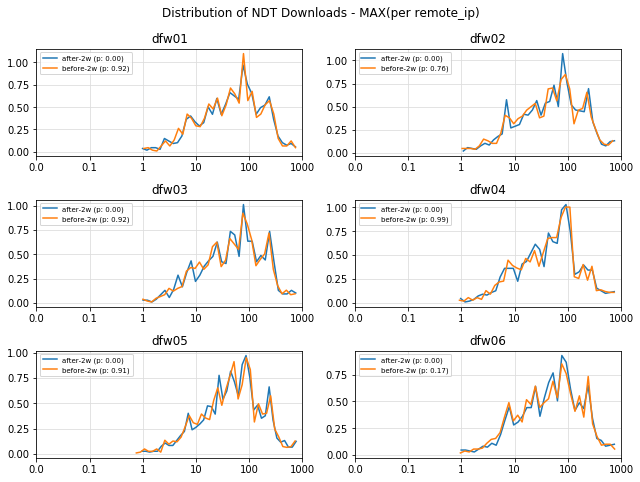

In [12]:
values = {}
def ks_compare(r, figure='', axis='', group='', size=''):
    values["%s-%s-%s" % (figure, axis, group)] = r
    if group == 'before-2w':
        after = values["%s-%s-%s" % (figure, axis, 'after-2w')]
        result = stats.ks_2samp(r, after)
        if result.pvalue < 0.01:
            print 'diff', figure, axis, result
        return result.pvalue
    return 0
            
plot_hist(
    df_ndt_variance, 'download_max', lambda r: int(math.sqrt(len(r))),
    fig_by='metro', axes_by='site', group_by='period',
    suptitle='Distribution of NDT Downloads - MAX(per remote_ip)',
    label='{group} (p: {result:.2f})',
    title='{axis}', axes=(3, 2),
    xlim=(math.log10(.01), math.log10(1000)),
    cdf=False, xlog=True, figsize=(9, 7),
    fxn=ks_compare)

{u'DFW': (<Figure size 648x504 with 6 Axes>,
  array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb06fd27250>,
        dtype=object),
  [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)])}

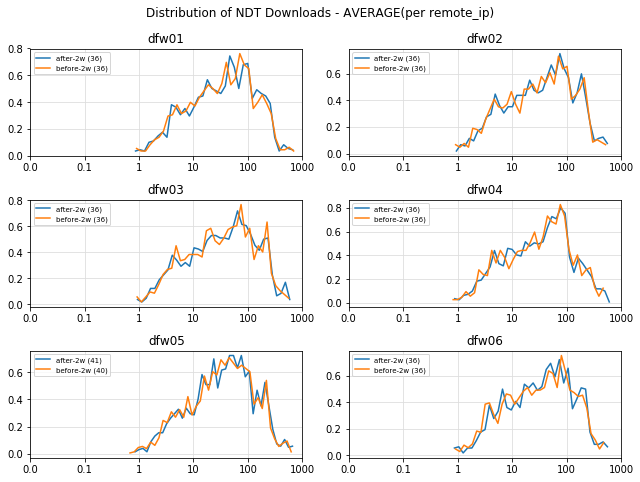

In [13]:
values = {}
def ks_compare(r, figure='', axis='', group='', size=''):
    values["%s-%s-%s" % (figure, axis, group)] = r
    if group == 'before-2w':
        after = values["%s-%s-%s" % (figure, axis, 'after-2w')]
        result = stats.ks_2samp(r, after)
        if result.pvalue < 0.01:
            print 'diff', figure, axis, result
        return result.pvalue
    return ''

plot_hist(
    df_ndt_variance, 'download_avg', lambda r: int(math.sqrt(len(r))),
    fig_by='metro', axes_by='site', group_by='period',
    suptitle='Distribution of NDT Downloads - AVERAGE(per remote_ip)',
    label='{group} ({size})',
    title='{axis}', axes=(3, 2),
    xlim=(math.log10(.01), math.log10(1000)),
    cdf=False, xlog=True, figsize=(9, 7),
    fxn=ks_compare)

# NDT Test Counts

In [14]:
import time
def query(site):
    print 'running query', site, time.ctime()
    return """
CREATE TEMPORARY FUNCTION
  timeBin(ts_usec INT64,
    size INT64) AS ( CAST(TRUNC(ts_usec / 1e6 / 10) * 10 AS INT64) );

WITH ndt_test_ids_with_discards AS (
  SELECT
    ndt.test_id as test_id,
    SUM(disco.discards) AS discards
  FROM (
    SELECT
      hostname,
      UNIX_SECONDS(sample.timestamp) - 10 AS tstart,
      UNIX_SECONDS(sample.timestamp) AS tend,
      sample.value AS discards
    FROM
      `measurement-lab.base_tables.switch*`,
      UNNEST(sample) AS sample
    WHERE
      metric = 'switch.discards.uplink.tx'
      AND sample.timestamp BETWEEN TIMESTAMP("2016-06-01") AND TIMESTAMP("2018-08-01")
      AND hostname = "mlab1."""+site+""".measurement-lab.org"
    GROUP BY
      hostname,
      tstart,
      tend,
      discards
    HAVING
      discards > 0
  ) AS disco
  JOIN (
    SELECT
      REGEXP_EXTRACT(connection_spec.server_hostname, r"(mlab1."""+site+""".measurement-lab.org)") as hostname,
      timeBin(web100_log_entry.snap.StartTimeStamp, 10) AS tstart,
      timeBin(web100_log_entry.snap.StartTimeStamp, 10) + 20 AS tend,
      test_id

    FROM
      `measurement-lab.release.ndt_all`
    WHERE
          log_time BETWEEN TIMESTAMP("2016-06-01") AND TIMESTAMP("2018-08-01")
      AND connection_spec.data_direction = 1
      AND (connection_spec.server_hostname = "mlab1."""+site+""".measurement-lab.org" OR connection_spec.server_hostname = "ndt.iupui.mlab1."""+site+""".measurement-lab.org")
      AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) >= 9000000
      AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) < 600000000
      AND web100_log_entry.snap.HCThruOctetsAcked >= 1000000

    GROUP BY
      test_id,
      hostname,
      tstart,
      tend ) AS ndt
  ON (disco.hostname = ndt.hostname
      AND (disco.tstart = ndt.tstart OR disco.tend = ndt.tend))
  GROUP BY
    test_id
  )


SELECT
  day, metro, site, hostname, discards, COUNT(*) as count

FROM
(
  SELECT
    TIMESTAMP_TRUNC(log_time, DAY) as day,
    UPPER(REGEXP_EXTRACT(connection_spec.server_hostname, r'mlab[1-4].([a-z]{3})[0-9]{2}.*')) AS metro,
    REGEXP_EXTRACT(connection_spec.server_hostname, r'mlab[1-4].([a-z]{3}[0-9]{2}).*') AS site,
    REGEXP_EXTRACT(connection_spec.server_hostname, r'(mlab[1-4].[a-z]{3}[0-9]{2}).*') AS hostname,
    CASE
      WHEN test_id IN(SELECT test_id from ndt_test_ids_with_discards) THEN 'non-zero'
      ELSE 'zero'
    END as discards

  FROM
    `measurement-lab.release.ndt_all`
    
  WHERE
        log_time BETWEEN TIMESTAMP("2016-06-01") AND TIMESTAMP("2018-08-01")
    AND connection_spec.data_direction = 1
    AND (connection_spec.server_hostname = "mlab1."""+site+""".measurement-lab.org" OR connection_spec.server_hostname = "ndt.iupui.mlab1."""+site+""".measurement-lab.org")
    AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) >= 9000000
    AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) < 600000000
    AND web100_log_entry.snap.HCThruOctetsAcked >= 1000000
  )
GROUP BY
  day, metro, site, hostname, discards
"""


df_test_counts = pd.concat([
    run_query(query("dfw01")),
    run_query(query("dfw02")),
    run_query(query("dfw03")),
    run_query(query("dfw04")),
    run_query(query("dfw05")),
    run_query(query("dfw06")),
])

running query dfw01 Fri Aug 31 16:35:39 2018
running query dfw02 Fri Aug 31 16:36:13 2018
running query dfw03 Fri Aug 31 16:40:30 2018
running query dfw04 Fri Aug 31 16:43:04 2018
running query dfw05 Fri Aug 31 16:44:45 2018
running query dfw06 Fri Aug 31 16:48:17 2018


Index([u'count', u'day', u'discards', u'hostname', u'metro', u'site'], dtype='object')


{u'DFW': (<Figure size 864x720 with 6 Axes>,
  array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb06e7f12d0>,
        dtype=object),
  [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)])}

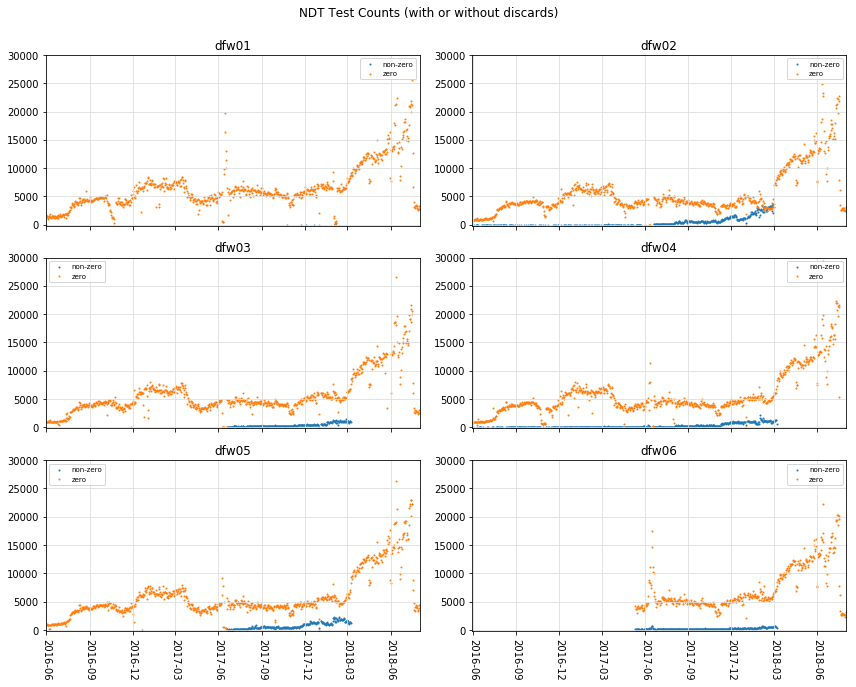

In [15]:
# NOTE: does not preserve binsize across group_by. Each line re-calculates the bin size.
print df_test_counts.keys()
plot_scatter(
    df_test_counts, 'day', 'count',
    fig_by='metro', axes_by='site', group_by='discards',
    suptitle='NDT Test Counts (with or without discards)',
    label='{group}',
    title='{axis}',
    axes=(3, 2), figsize=(12, 10),
    ylim=(-200, 30000),
    xlim=(pd.to_datetime("2016-05-31"), pd.to_datetime("2018-08-01")),
    fx=lambda l: [pd.to_datetime(t) for t in l])